<a href="https://colab.research.google.com/github/johnkansas/malaria_image_classification/blob/main/rgb_image_deeplearning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# 옆에 파일 부분에 구글 드라이브에 접속 할수 있음 >> 목표는 zip 파일을 여는것.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets

여기 링크에 가서 데이터 다운로드
다운로드된 파일을 test,train , parasitized, uninfected으로 나누어서 class를 자동으로 분류하는 코드 만들기

unzip을 하면 바로 현재 위치에서 파일 확인 가능
parasitized와 uninfected 비교

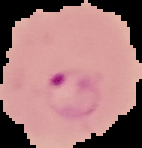
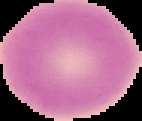

In [ ]:
!unzip "/content/gdrive/My Drive/malaria/cell_images.zip"

In [ ]:
test_path = "test/"
train_path = "train/"

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as imread

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

아래는 datasets.imagefolder 코드를 쓸때 colab에서 생기는 버그를 해결한 내용.

In [ ]:
!rm -R train/.ipynb_checkpoints
!ls train/ -a  

rm: cannot remove 'train/.ipynb_checkpoints': No such file or directory
.  ..  Parasitized  Uninfected


In [ ]:
!rm -R test/.ipynb_checkpoints
!ls test/ -a 

.  ..  Parasitized  Uninfected


이미지 사이즈를 지정해주고,transforms코드를 활용해 데이터를 미리 코드에 잘 적용 될수 있도록 만들어 줍니다.

In [ ]:
image_size = (130, 130)

In [ ]:
train_transform=transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize(image_size),
    transforms.ToTensor()
])
test_transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [ ]:
# EXAMPLE USAGE:
# instantiate the dataset and dataloader

testset = datasets.ImageFolder("./test",transform=test_transform) # our custom dataset
testloader = DataLoader(testset,batch_size=16)
trainset = datasets.ImageFolder(train_path,train_transform) # our custom dataset
trainloader = DataLoader(trainset,batch_size=16, shuffle=True)



# iterate over data
for inputs, labels in trainloader:
    # use the above variables freely
    print(inputs.size(),inputs.sum(), labels)
print(len(testset))
# for inputs, labels, paths in trainloader:
#     # use the above variables freely
#     print(inputs, labels, paths)

(W-F+2*P)/S +1=output size


W: image width >>input size


F: filter width >> channel의 개수


P: padding size >> 계산 할때 데이터 보존하기 위한 방법


S: stride number >> 계산 시간을 단축하기 위해 띄엄띄엄 계산하기

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sig=nn.Sigmoid()
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))#>>64,64,32
        x = self.pool(F.relu(self.conv2(x)))#>>31,31,64
        x = self.pool(F.relu(self.conv3(x)))#>>14,14,64
        x = torch.flatten(x,1) # flatten all dimensions except batch>>12544
        # print("after flatten",x.size())
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        # print("after drop",x.size())
        x = self.fc2(x)
        x = self.sig(x)
        # print("after fc2",x.size())
        # x=x.squeeze()
        # x=torch.FloatTensor(x)
        # torch.reshape(x, (-1,))
        return x


net = Net()

# 출력 사이즈 생성자 만들때 뭐 넣을지 아무것도 지정 안함.
# fc에 비해 계산이 까다로움 >> 입출력이 맞아야함.

이진 분류 방법인 binary cross entropy 사용


adam이 가장 좋은것으로 알려져 있어서 사용

In [ ]:
import torch.optim as optim

criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)#optimizer 안에 넣는다.

학습 시킨 결과 loss가 줄어든 모습 확인 가능

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times# trainer의 train함수

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        optimizer.zero_grad()
        outputs =net(inputs)
        oo=torch.flatten(outputs)
        loss = criterion(oo,labels.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.086
[2,  1000] loss: 0.084
[3,  1000] loss: 0.083
Finished Training


학습에 사용했던 

```
# 코드로 형식 지정됨
```

매개변수 저장

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

학습에 사용했던 매개변수 불러오기



In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

test 검증 결과 0.5크기로 분류하여 정답률이 더 낮을수도 있습니다.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        oo=torch.flatten(outputs)
        for i in range(len(oo)):
          total+=1
          if oo[i]>0.5:
            a=1
          elif oo[i]<0.5:
            a=0
          if a==labels[i]:
            correct+=1

print(f'Accuracy of the network on the 5512 test images: {100 * correct // total} %')

Accuracy of the network on the 5512 test images: 93 %
